### Emotion Detactor

* Name: Baldur Hua

* [Github link](https://github.com/BaldurHua/STAT6289-Deep-Learning)

* [Dataset](https://www.kaggle.com/himanigulati/expressions)

In [1]:
import os
import torch
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
#%%
# Get working directory
filepath = os.path.join(os.getcwd())
# Read data file
df = pd.read_csv(os.path.join(filepath, "fer2013.csv"))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
classes = sorted(df['emotion'].unique())
classes

[0, 1, 2, 3, 4, 5, 6]

In [5]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

####  Category: 
* 0=Angry
* 1=Disgust 
* 2=Fear 
* 3=Happy 
* 4=Sad
* 5=Surprise
* 6=Neutral

In [6]:
classes = {0:'Angry', 1:'Disgust',
          2:'Fear', 3:'Happy',
          4:'Sad', 5:'Surprise', 
          6:'Neutral'}
classes

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [7]:
class PixConv:
    def __init__(self, data):
        self.x_train, self.y_train = [],  []
        self.x_test, self.y_test = [], []
        self.x_valid, self.y_valid = [], []

        for ind, x in enumerate(data.values):
            pixels = []
            label = None
            for indx, i in enumerate(x[1].split(' ')):
                pixels.append(int(i))
            pixels = np.array(pixels).reshape((1, 48, 48))

            if x[2] == 'Training':
                self.x_train.append(pixels)
                self.y_train.append(int(x[0]))
            elif x[2] == 'PublicTest':
                self.x_test.append(pixels)
                self.y_test.append(int(x[0]))
            else:
                self.x_valid.append(pixels)
                self.y_valid.append(int(x[0]))
        self._x_train, self.y_train = np.array(self.x_train).reshape((len(self.x_train), 1, 48, 48)),\
            np.array(self.y_train, dtype=np.int64)
        self._x_test, self.y_test = np.array(self.x_test).reshape((len(self.x_test), 1, 48, 48)),\
            np.array(self.y_test, dtype=np.int64)
        self._x_valid, self.y_valid = np.array(self.x_valid).reshape((len(self.x_valid), 1, 48, 48)),\
            np.array(self.y_valid, dtype=np.int64)

In [8]:
img = PixConv(df)

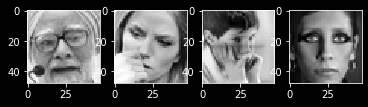

In [9]:
img.x_train = np.asarray(img.x_train, dtype=np.float64)
img.x_train -= np.mean(img.x_train, axis = 0)
fig = plt.figure()
for i in range(1, 5):
    imgs = img.x_train[i].reshape((48, 48))
    fig.add_subplot(1, 4, i)
    plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [10]:
# image tensor and the label
# reference source: https://github.com/AsutoshPadhi/fer-2013/blob/master/src/fer.py
class CreateData(torch.utils.data.Dataset):
    def __init__(self, X, Y, transforms=None):
        self.transforms = transforms
        self.img = X
        self.labs = Y
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        imgs = self.img[index]
        labls = self.labs[index]
        
        if self.transforms:
            imgs = self.transforms(np.uint8(imgs))
        return (imgs, labls)

In [11]:
class CreateData2(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
       
        if self.transforms:
            image = self.transforms(image)
            
        return image.clone().detach(), label

In [12]:
# Load the dataset 
# Augmentation tsfm
df_train = df[df['Usage']=='Training']
df_valid = df[df['Usage']=='PublicTest']
df_test = df[df['Usage']=='PrivateTest']

df_valid = df_valid.reset_index(drop=True) 
df_test = df_test.reset_index(drop = True)

transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5))])

transform2 = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5), (0.5))])

batch_size = 16

trainset =  CreateData2(df_train, transform)
validset = CreateData2(df_valid, transform2)
testset = CreateData2(df_test, transform2)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, num_workers=0)

validloader = torch.utils.data.DataLoader(validset, 
                                         batch_size=batch_size, 
                                         shuffle=False, num_workers=0)


testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False, num_workers=0)

In [13]:
class CNN(nn.Module): # num_of_class = 7  48*48*1
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(16*20*20, 512)
        self.fc2 = nn.Linear(512, 144)
        self.fc3 = nn.Linear(144,7)
        self.drop = nn.Dropout(0.5)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x
    
net = CNN()

In [14]:
import torch.optim as optim

def ModAcc(model, epochs, dataloader_train, dataloader_test):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_acc = []
    test_acc = []
    for epoch in range(epochs): 
        train_correct = 0
        train_total = 0
        model.train()
        for i, data in enumerate(dataloader_train, 0):
            inputs, train_labels = data
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            
            predicted_train = torch.max(outputs, 1)[1].data.squeeze() 
            train_total += train_labels.size(0)
            train_correct += (predicted_train == train_labels).sum().item()
        train_acc.append(train_correct / train_total)
    
    # Validation

        test_correct = 0
        test_total = 0
        model.eval()
        with torch.no_grad():
            for data in dataloader_test:
                images, test_labels = data
                images, test_labels = images.to(device), test_labels.to(device)

                scores = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted_test = torch.max(scores.data, 1)
                test_total += test_labels.size(0)
                test_correct += (predicted_test == test_labels).sum().item()
            test_acc.append(test_correct / test_total)

            print("Epoch {}/{}, Train Accuracy: {:.3f}, Validation Accuracy:{:.3f}".format(
                epoch+1, epochs, train_correct / train_total, test_correct / test_total))
    return [train_acc, test_acc]

In [15]:
net.to(device)
Acc = ModAcc(net, 30, trainloader, validloader)

Epoch 1/30, Train Accuracy: 0.336, Validation Accuracy:0.428
Epoch 2/30, Train Accuracy: 0.434, Validation Accuracy:0.492
Epoch 3/30, Train Accuracy: 0.470, Validation Accuracy:0.511
Epoch 4/30, Train Accuracy: 0.491, Validation Accuracy:0.525
Epoch 5/30, Train Accuracy: 0.506, Validation Accuracy:0.536
Epoch 6/30, Train Accuracy: 0.518, Validation Accuracy:0.536
Epoch 7/30, Train Accuracy: 0.529, Validation Accuracy:0.551
Epoch 8/30, Train Accuracy: 0.536, Validation Accuracy:0.555
Epoch 9/30, Train Accuracy: 0.542, Validation Accuracy:0.549
Epoch 10/30, Train Accuracy: 0.547, Validation Accuracy:0.555
Epoch 11/30, Train Accuracy: 0.555, Validation Accuracy:0.559
Epoch 12/30, Train Accuracy: 0.559, Validation Accuracy:0.552
Epoch 13/30, Train Accuracy: 0.564, Validation Accuracy:0.561
Epoch 14/30, Train Accuracy: 0.568, Validation Accuracy:0.565
Epoch 15/30, Train Accuracy: 0.577, Validation Accuracy:0.573
Epoch 16/30, Train Accuracy: 0.579, Validation Accuracy:0.564
Epoch 17/30, Trai

In [16]:
PATH = './emo_net.pth'
torch.save(net.state_dict(), PATH)

In [17]:
Acc_Train = Acc[0]
Acc_Test = Acc[1]

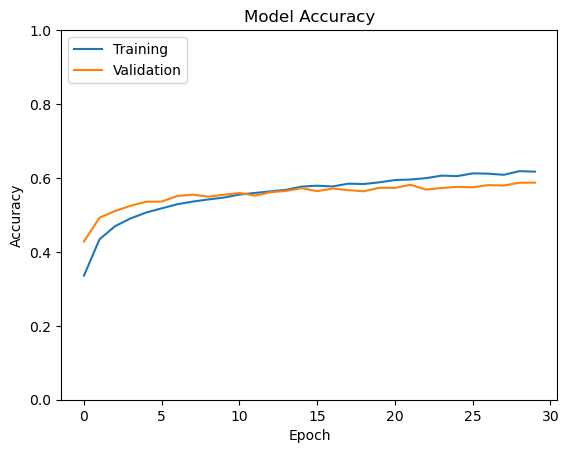

In [18]:
plt.style.use('default')
plt.plot(Acc_Train, label='Training')
plt.plot(Acc_Test, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper left')

In [19]:
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
net.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, test_labels = data
        images, test_labels = images.to(device), test_labels.to(device)
        scores = net(images)
        _, predicted_test = torch.max(scores.data, 1)
        total += test_labels.size(0)
        correct += (predicted_test == test_labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 54 %


In [21]:
def predict(img, model):
    x = img.unsqueeze(0)
    y = model(x)
    _, preds  = torch.max(y, dim=1)
    return classes[preds[0].item()]

Label: Neutral , Predicted: Neutral


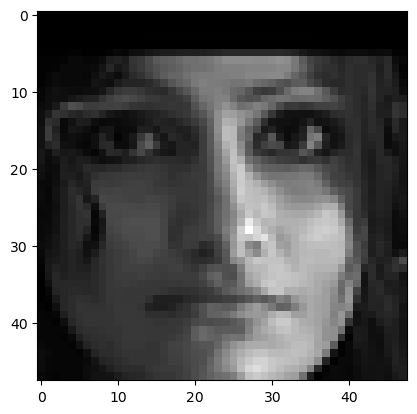

In [24]:
img, label = testset[15]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)

print('Label:', classes[label], ', Predicted:', predict(img, net))

Label: Happy , Predicted: Happy


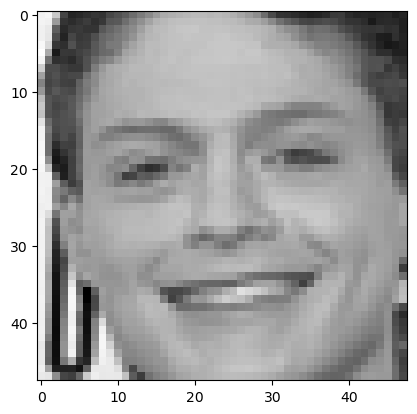

In [23]:
img, label = testset[1000]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)

print('Label:', classes[label], ', Predicted:', predict(img, net))

In [25]:
import cv2

In [30]:
vid = cv2.VideoCapture(os.path.join(filepath, "Test Video.mp4"))
net.to(device)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
cv2.namedWindow('frame',0)
cv2.resizeWindow('frame', 1440, 720)
out = cv2.VideoWriter('demo.avi', fourcc, 20.0, (1440, 720))

while True:
    ret, frame = vid.read()
    frame = cv2.resize(frame, (1440, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=4)

    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w+20, y+h+20), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = cv2.resize(roi_gray_frame, (48, 48))
        cropped_img = np.expand_dims(cropped_img, 0)
        cropped_img = torch.from_numpy(cropped_img).float()
        cropped_img = cropped_img.to(device)

        emotion_prediction = predict(cropped_img, net)
        cv2.putText(frame, emotion_prediction, (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
    out.write(frame)
out.release()
vid.release()
cv2.destroyAllWindows()

In [ ]:
# Run Above